Now that we have picked two schedules with selected trials (reward-effort pairings) to include, this script will create 16 unique schedules:
- 2 schedules with 2 trial-orders (2 approach (/avoid) blocks will have one order, the other 2 approach (/avoid) blocks will have another order)
    - Block 1: Approach (/avoid), heart rate, normal effort --> trial-order 1
    - Block 2: Approach (/avoid), heart rate, shifted effort --> trial-order 2
    - Block 3: Approach (/avoid), reward rate, normal effort --> trial-order 1
    - Block 4: Approach (/avoid), reward rate, shifted effort --> trial-order 2
- change action type after 4 blocks, change attentional focus after every 2 blocks, change global effort state after every 1 block
- counter balanacing all orders (start with approach vs avoid, with heart vs reward, with normal vs shifted) gives 2x2x2 = 8 possbile block orders (or x 2 = 16 if also counter balancing trial order)
- 2 schedules x 8 block orders = 16 unique schedules
- 3 x 2 x 1 = 6 TUS session orders 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import random

In [2]:
# Function to place heart and reward rate ratings

def determine_ratings(df, seed):
    # Set the seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    # Ensure we are working with a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Create the 'rating' column, initially set to False for all rows
    df.loc[:, 'rating'] = False
    
    # Define high/low outcome
    high_outcome = df[abs(df['outcome_level']) > 60]
    low_outcome = df[abs(df['outcome_level']) < 60]
    
    # Select rating trials (pair each high/low outcome with high/medium/low effort and last trial)
    rating_trials = []
    if not high_outcome[high_outcome['effort'] < 70].empty:
        rating_trials.append(high_outcome[high_outcome['effort'] < 70].sample(n=1, random_state=seed).index[0])  # 50, 55, 60, 65
    if not high_outcome[(high_outcome['effort'] > 65) & (high_outcome['effort'] < 85)].empty:
        rating_trials.append(high_outcome[(high_outcome['effort'] > 65) & (high_outcome['effort'] < 85)].sample(n=1, random_state=seed).index[0])  # 70, 75, 80
    if not high_outcome[high_outcome['effort'] > 80].empty:
        rating_trials.append(high_outcome[high_outcome['effort'] > 80].sample(n=1, random_state=seed).index[0])  # 85, 90, 95, 100
    if not low_outcome[low_outcome['effort'] < 70].empty:
        rating_trials.append(low_outcome[low_outcome['effort'] < 70].sample(n=1, random_state=seed).index[0])
    if not low_outcome[(low_outcome['effort'] > 65) & (low_outcome['effort'] < 85)].empty:
        rating_trials.append(low_outcome[(low_outcome['effort'] > 65) & (low_outcome['effort'] < 85)].sample(n=1, random_state=seed).index[0])  # 70, 75, 80
    if not low_outcome[low_outcome['effort'] > 80].empty:
        rating_trials.append(low_outcome[low_outcome['effort'] > 80].sample(n=1, random_state=seed).index[0])
    rating_trials.append(df.index[-1])

    # Set 'rating' to True for selected trials
    df.loc[rating_trials, 'rating'] = True
    
    # Arrange trials with spacing
    non_rating_trials = df[~df['rating']].index.tolist()
    random.shuffle(non_rating_trials)
    random.shuffle(rating_trials)
    new_order = []
    last_rating_trial = rating_trials.pop()  # Remove the last trial
    while rating_trials or non_rating_trials:
        # Add non-rating trials
        spacing = np.random.randint(4, 11)
        new_order.extend(non_rating_trials[:spacing])
        non_rating_trials = non_rating_trials[spacing:]
        # Add a rating trial if available
        if rating_trials:
            new_order.append(rating_trials.pop(0))
    
    # Add remaining non-rating trials and the last rating trial
    new_order.extend(non_rating_trials)
    new_order.append(last_rating_trial)
    
    # Reorder the dataframe
    df = df.loc[new_order].reset_index(drop=True)
    
    # Print rating trial types and their positions
    for i, idx in enumerate(df[df['rating']].index):
        if df.loc[idx, 'effort'] > 80:
            effort = 'high'
        elif df.loc[idx, 'effort'] < 70:
            effort = 'low'
        else:
            effort = 'medium'
        outcome = 'high' if abs(df.loc[idx, 'outcome_level']) > 60 else 'low'
        print(f"Rating trial {i+1}: {effort} effort, {outcome} outcome - Trial number {idx+1}")
    
    return df



In [3]:
# Normalize function

def normalize(data):
    data = abs(data)
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:

def process_schedule(schedule, seed, window_size=5):
    # Copy and shuffle the trial order
    schedule_order = schedule.copy()
    schedule_order = determine_ratings(schedule_order, seed=seed)  # Shuffle trial order and place rating trials
    schedule_order['trial_in_block'] = range(1, len(schedule_order) + 1)

    # Extract relevant columns
    outcomes = schedule_order['outcome_level']
    efforts = schedule_order['effort']

    # Normalize data
    normalized_outcomes = normalize(outcomes)
    normalized_efforts = normalize(efforts)
    indices = range(1, len(schedule_order) + 1)

    # Convert normalized data to pandas Series for rolling correlation calculation
    series_normalized_outcomes = pd.Series(normalized_outcomes)
    series_normalized_efforts = pd.Series(normalized_efforts)

    # Calculate rolling correlation
    rolling_corr = series_normalized_outcomes.rolling(window=window_size).corr(series_normalized_efforts)

    # Plotting the results
    plt.figure(figsize=(12, 4))
    plt.plot(indices, normalized_outcomes, label='Normalized Outcome Level', color='green', alpha=0.7)
    plt.plot(indices, normalized_efforts, label='Normalized Effort', color='orange', alpha=0.8)
    plt.plot(rolling_corr.index, rolling_corr, label='Rolling Correlation', color='blue')
    plt.xticks(range(1, len(schedule_order) + 1), rotation=45)
    plt.ylim(-0.9, 1.1)
    plt.xlabel('Trial in Block')
    plt.ylabel('Value')
    plt.hlines(0, 0, len(schedule_order), colors='gray', linestyles='dashed', linewidth=1)
    for idx in schedule_order[schedule_order['rating']]['trial_in_block']:  # Add vertical lines for trials where rating is True
        plt.axvline(x=idx, color='red', linestyle='dotted', linewidth=1)
    plt.title(f'Normalized Outcome and Effort Levels with Rolling Correlation (Window = {window_size})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate overall correlation
    overall_corr = np.corrcoef(normalized_outcomes, normalized_efforts)[0, 1]
    print(f"Overall Correlation = {overall_corr:.2f}")

    # Sanity checks that schedules remain the same just with different orders
    print("Average outcome in the original schedule:", schedule['actual_outcome'].mean())
    print("Average outcome in the processed schedule:", schedule_order['actual_outcome'].mean())
    print("Average effort level in the original schedule:", schedule['effort'].mean())
    print("Average effort level in the processed schedule:", schedule_order['effort'].mean())

    return schedule_order



### Schedule A

In [5]:
# Load the schedule
schedule_A = pd.read_csv('../generate_trial_schedules/trial_schedule_1.csv')
schedule_A = schedule_A.iloc[:, 1:-2]

# Separate the schedules by action type
schedule_A_approach = schedule_A[schedule_A['action_type'] == 'approach']
schedule_A_avoid = schedule_A[schedule_A['action_type'] == 'avoid']

#### Approach - Order 1

Rating trial 1: low effort, high outcome - Trial number 6
Rating trial 2: medium effort, low outcome - Trial number 16
Rating trial 3: low effort, low outcome - Trial number 25
Rating trial 4: high effort, high outcome - Trial number 30
Rating trial 5: high effort, low outcome - Trial number 36
Rating trial 6: high effort, low outcome - Trial number 44
Rating trial 7: medium effort, high outcome - Trial number 50


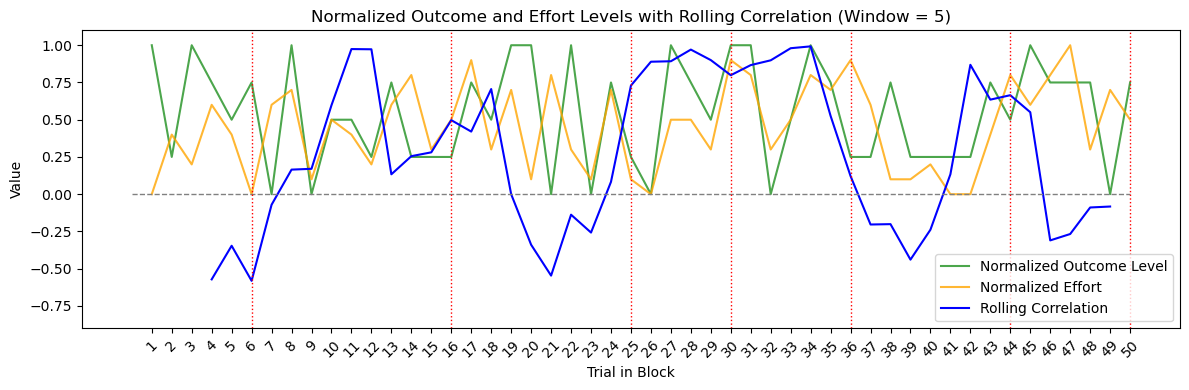

Overall Correlation = 0.25
Average outcome in the original schedule: 64.34
Average outcome in the processed schedule: 64.34
Average effort level in the original schedule: 72.6
Average effort level in the processed schedule: 72.6


In [6]:
schedule_A_approach_order1 = process_schedule(schedule_A_approach, seed=10)

#### Approach - Order 2

Rating trial 1: low effort, high outcome - Trial number 11
Rating trial 2: high effort, low outcome - Trial number 19
Rating trial 3: low effort, low outcome - Trial number 29
Rating trial 4: high effort, low outcome - Trial number 34
Rating trial 5: medium effort, low outcome - Trial number 39
Rating trial 6: medium effort, high outcome - Trial number 46
Rating trial 7: high effort, high outcome - Trial number 50


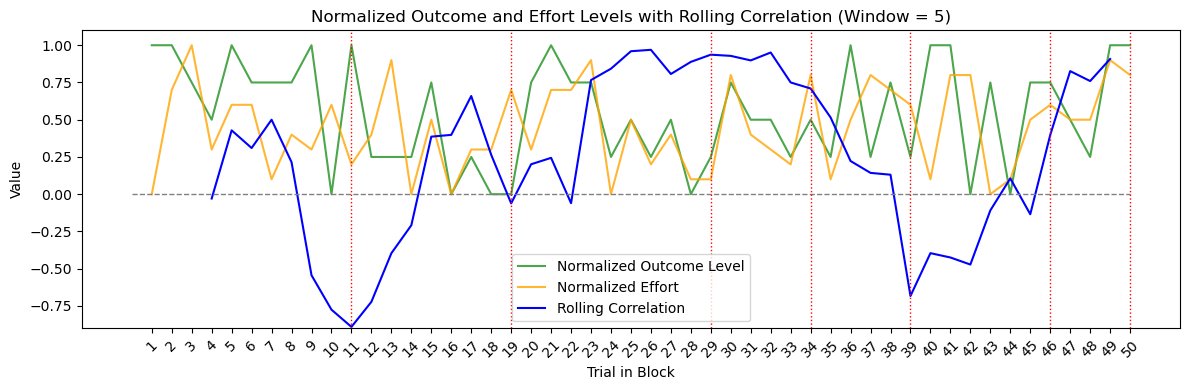

Overall Correlation = 0.25
Average outcome in the original schedule: 64.34
Average outcome in the processed schedule: 64.34
Average effort level in the original schedule: 72.6
Average effort level in the processed schedule: 72.6


In [7]:
schedule_A_approach_order2 = process_schedule(schedule_A_approach, seed=40)

#### Avoid - Order 1

Rating trial 1: high effort, high outcome - Trial number 5
Rating trial 2: low effort, low outcome - Trial number 10
Rating trial 3: high effort, low outcome - Trial number 18
Rating trial 4: low effort, high outcome - Trial number 28
Rating trial 5: low effort, low outcome - Trial number 34
Rating trial 6: medium effort, high outcome - Trial number 45
Rating trial 7: medium effort, low outcome - Trial number 50


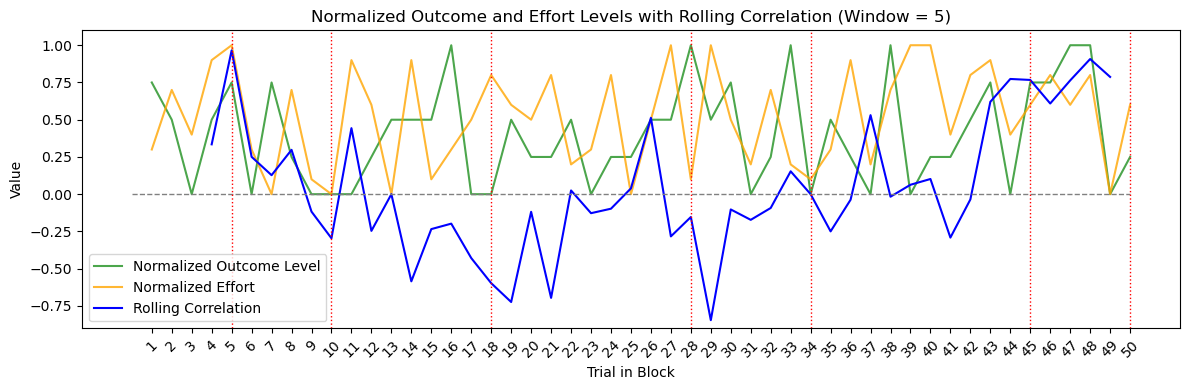

Overall Correlation = 0.11
Average outcome in the original schedule: -52.16
Average outcome in the processed schedule: -52.16
Average effort level in the original schedule: 76.0
Average effort level in the processed schedule: 76.0


In [8]:
schedule_A_avoid_order1 = process_schedule(schedule_A_avoid, seed=50)

#### Avoid - Order 2

Rating trial 1: medium effort, low outcome - Trial number 5
Rating trial 2: high effort, high outcome - Trial number 10
Rating trial 3: low effort, low outcome - Trial number 18
Rating trial 4: high effort, low outcome - Trial number 23
Rating trial 5: low effort, high outcome - Trial number 30
Rating trial 6: low effort, low outcome - Trial number 41
Rating trial 7: medium effort, high outcome - Trial number 50


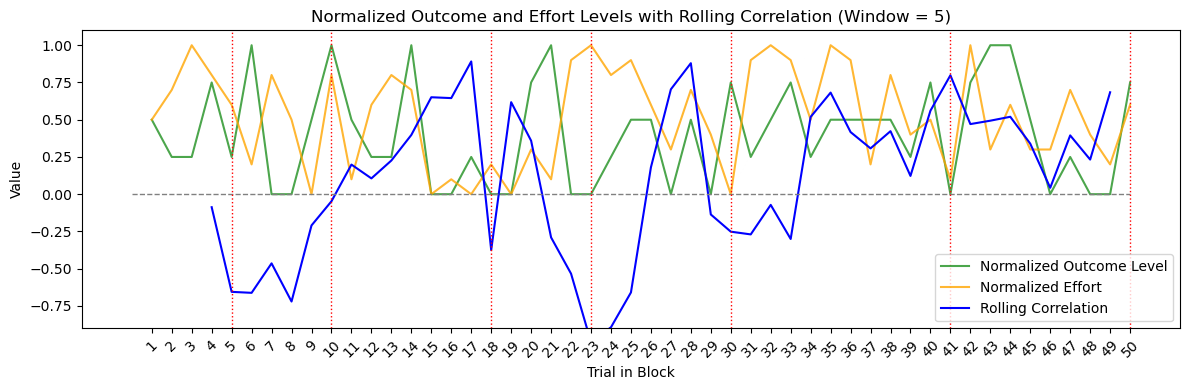

Overall Correlation = 0.11
Average outcome in the original schedule: -52.16
Average outcome in the processed schedule: -52.16
Average effort level in the original schedule: 76.0
Average effort level in the processed schedule: 76.0


In [9]:
schedule_A_avoid_order2 = process_schedule(schedule_A_avoid, seed=(100))

#### Schedule A 1-8

In [10]:
# Define the block order patterns
action_type_patterns = [
    ['approach', 'approach', 'approach', 'approach', 'avoid', 'avoid', 'avoid', 'avoid'],
    ['avoid', 'avoid', 'avoid', 'avoid', 'approach', 'approach', 'approach', 'approach']
]
trial_order_patterns = [
    ['order1', 'order2', 'order1', 'order2', 'order1', 'order2', 'order1', 'order2']
]
attention_focus_patterns = [
    ['heart', 'heart', 'reward', 'reward', 'heart', 'heart', 'reward', 'reward'],
    ['reward', 'reward', 'heart', 'heart', 'reward', 'reward', 'heart', 'heart']
]
global_effort_state_patterns = [
    ['normal', 'shifted', 'normal', 'shifted', 'normal', 'shifted', 'normal', 'shifted'],
    ['shifted', 'normal', 'shifted', 'normal', 'shifted', 'normal', 'shifted', 'normal']
]

# Function to create a schedule from a given pattern
def create_schedule(action_type_pattern, trial_order_pattern, attention_focus_pattern, global_effort_state_pattern):
    trial_schedule = []
    trial_in_experiment = 1

    for block_number in range(8):
        action_type = action_type_pattern[block_number]
        trial_order = trial_order_pattern[block_number]
        attention_focus = attention_focus_pattern[block_number]
        global_effort_state = global_effort_state_pattern[block_number]

        if action_type == 'approach':
            df = schedule_A_approach_order1.copy() if trial_order == 'order1' else schedule_A_approach_order2.copy()
        else:
            df = schedule_A_avoid_order1.copy() if trial_order == 'order1' else schedule_A_avoid_order2.copy()

        df['trial_order'] = trial_order
        df['attention_focus'] = attention_focus
        df['global_effort_state'] = global_effort_state
        df['trial_in_experiment'] = range(trial_in_experiment, trial_in_experiment + len(df))
        df['block_number'] = block_number + 1
        trial_in_experiment += len(df)
        trial_schedule.append(df)

    return pd.concat(trial_schedule)


# Generate the 8 possible schedules
schedules = []
for i, action_type_pattern in enumerate(action_type_patterns):
    for j, trial_order_pattern in enumerate(trial_order_patterns):
        for k, attention_focus_pattern in enumerate(attention_focus_patterns):
            for l, global_effort_state_pattern in enumerate(global_effort_state_patterns):
                schedule = create_schedule(action_type_pattern, trial_order_pattern, attention_focus_pattern, global_effort_state_pattern)
                schedules.append(schedule)
                schedule['schedule_version'] = f'schedule_A_{len(schedules)}'
                file_name = f'schedule_A_{len(schedules)}.csv'
                schedule.to_csv(file_name, index=False)
                print(f'Saved {file_name}')

Saved schedule_A_1.csv
Saved schedule_A_2.csv
Saved schedule_A_3.csv
Saved schedule_A_4.csv
Saved schedule_A_5.csv
Saved schedule_A_6.csv
Saved schedule_A_7.csv
Saved schedule_A_8.csv


In [11]:
check_schedule = pd.read_csv('schedule_A_1.csv')
check_schedule

,outcome_level,actual_outcome,effort,action_type,rating,trial_in_block,trial_order,attention_focus,global_effort_state,trial_in_experiment,block_number,schedule_version
0,100,95,50,approach,False,1,order1,heart,normal,1,1,schedule_A_1
1,40,38,70,approach,False,2,order1,heart,normal,2,1,schedule_A_1
2,100,119,60,approach,False,3,order1,heart,normal,3,1,schedule_A_1
3,80,74,80,approach,False,4,order1,heart,normal,4,1,schedule_A_1
4,60,71,70,approach,False,5,order1,heart,normal,5,1,schedule_A_1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,-20,-19,65,avoid,False,46,order2,reward,shifted,396,8,schedule_A_1
396,-40,-32,85,avoid,False,47,order2,reward,shifted,397,8,schedule_A_1
397,-20,-16,70,avoid,False,48,order2,reward,shifted,398,8,schedule_A_1
398,-20,-21,60,avoid,False,49,order2,reward,shifted,399,8,schedule_A_1


### Schedule B

In [12]:
# Load the schedule
schedule_B = pd.read_csv('../generate_trial_schedules/trial_schedule_13.csv')
schedule_B = schedule_B.iloc[:, 1:-2]

# Separate the schedules by action type
schedule_B_approach = schedule_B[schedule_B['action_type'] == 'approach']
schedule_B_avoid = schedule_B[schedule_B['action_type'] == 'avoid']


#### Approach - Order 1

Rating trial 1: high effort, high outcome - Trial number 8
Rating trial 2: low effort, low outcome - Trial number 15
Rating trial 3: high effort, low outcome - Trial number 24
Rating trial 4: high effort, low outcome - Trial number 31
Rating trial 5: low effort, high outcome - Trial number 37
Rating trial 6: medium effort, low outcome - Trial number 46
Rating trial 7: medium effort, high outcome - Trial number 50


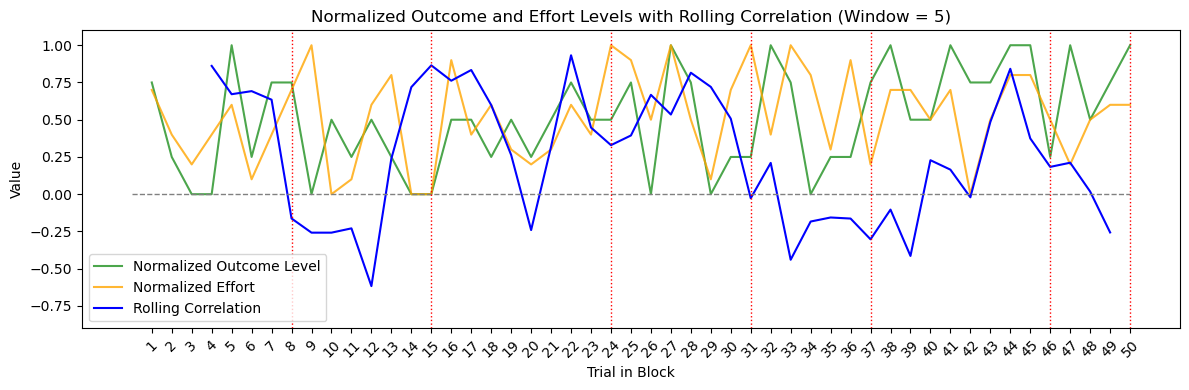

Overall Correlation = 0.25
Average outcome in the original schedule: 58.14
Average outcome in the processed schedule: 58.14
Average effort level in the original schedule: 76.1
Average effort level in the processed schedule: 76.1


In [13]:
schedule_B_approach_order1 = process_schedule(schedule_B_approach, seed=20)

#### Approach - Order 2

Rating trial 1: medium effort, low outcome - Trial number 9
Rating trial 2: high effort, high outcome - Trial number 16
Rating trial 3: low effort, high outcome - Trial number 24
Rating trial 4: medium effort, high outcome - Trial number 30
Rating trial 5: low effort, low outcome - Trial number 35
Rating trial 6: high effort, low outcome - Trial number 42
Rating trial 7: high effort, low outcome - Trial number 50


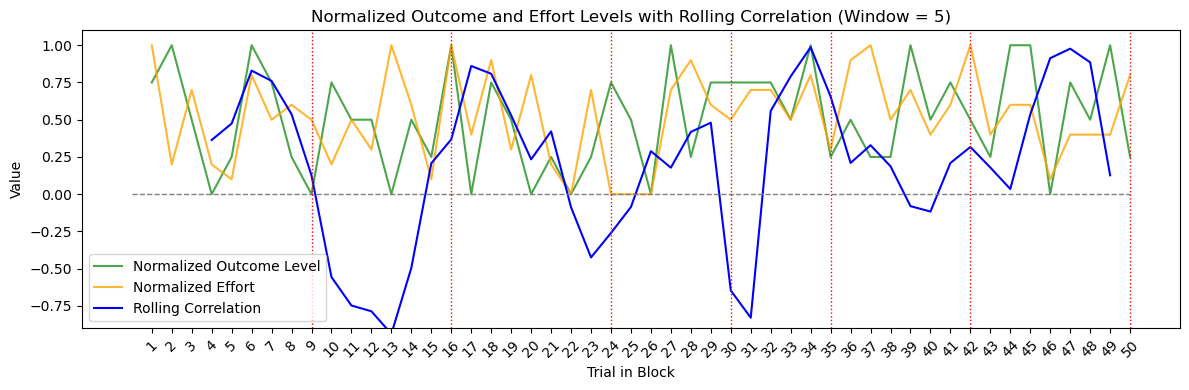

Overall Correlation = 0.25
Average outcome in the original schedule: 58.14
Average outcome in the processed schedule: 58.14
Average effort level in the original schedule: 76.1
Average effort level in the processed schedule: 76.1


In [14]:
schedule_B_approach_order2 = process_schedule(schedule_B_approach, seed=150)

#### Avoid - Order 1

Rating trial 1: high effort, low outcome - Trial number 5
Rating trial 2: medium effort, low outcome - Trial number 12
Rating trial 3: medium effort, high outcome - Trial number 17
Rating trial 4: low effort, high outcome - Trial number 23
Rating trial 5: high effort, high outcome - Trial number 31
Rating trial 6: medium effort, high outcome - Trial number 40
Rating trial 7: low effort, low outcome - Trial number 50


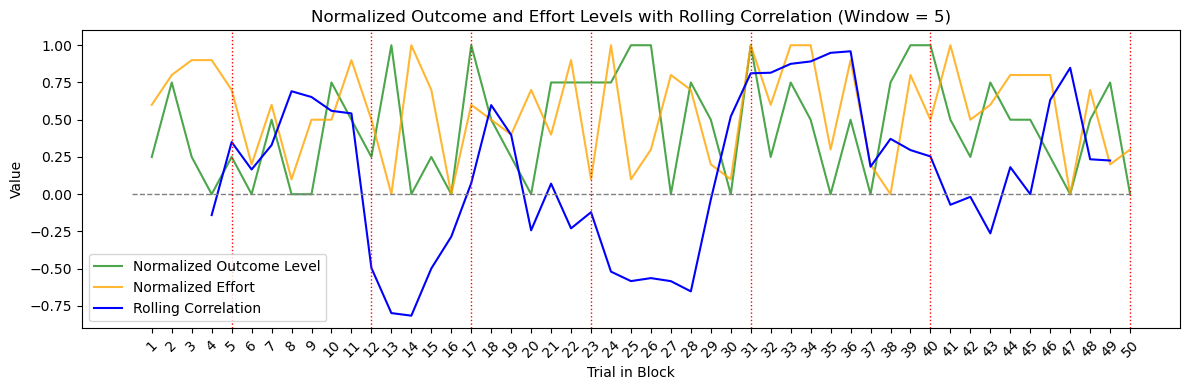

Overall Correlation = 0.11
Average outcome in the original schedule: -55.46
Average outcome in the processed schedule: -55.46
Average effort level in the original schedule: 77.7
Average effort level in the processed schedule: 77.7


In [15]:
schedule_B_avoid_order1 = process_schedule(schedule_B_avoid, seed=160)

#### Avoid - Order 2

Rating trial 1: medium effort, high outcome - Trial number 7
Rating trial 2: medium effort, high outcome - Trial number 13
Rating trial 3: low effort, low outcome - Trial number 18
Rating trial 4: low effort, high outcome - Trial number 27
Rating trial 5: high effort, high outcome - Trial number 34
Rating trial 6: high effort, low outcome - Trial number 43
Rating trial 7: medium effort, low outcome - Trial number 50


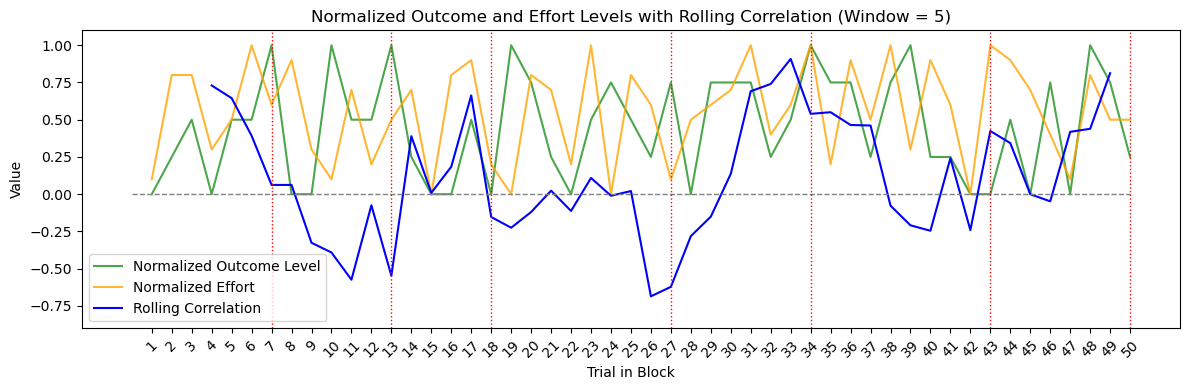

Overall Correlation = 0.11
Average outcome in the original schedule: -55.46
Average outcome in the processed schedule: -55.46
Average effort level in the original schedule: 77.7
Average effort level in the processed schedule: 77.7


In [16]:
schedule_B_avoid_order2 = process_schedule(schedule_B_avoid, seed=200)

#### Schedule B 1-8

In [17]:
# Define the block order patterns
action_type_patterns = [
    ['approach', 'approach', 'approach', 'approach', 'avoid', 'avoid', 'avoid', 'avoid'],
    ['avoid', 'avoid', 'avoid', 'avoid', 'approach', 'approach', 'approach', 'approach']
]
trial_order_patterns = [
    ['order1', 'order2', 'order1', 'order2', 'order1', 'order2', 'order1', 'order2']
]
attention_focus_patterns = [
    ['heart', 'heart', 'reward', 'reward', 'heart', 'heart', 'reward', 'reward'],
    ['reward', 'reward', 'heart', 'heart', 'reward', 'reward', 'heart', 'heart']
]
global_effort_state_patterns = [
    ['normal', 'shifted', 'normal', 'shifted', 'normal', 'shifted', 'normal', 'shifted'],
    ['shifted', 'normal', 'shifted', 'normal', 'shifted', 'normal', 'shifted', 'normal']
]

# Function to create a schedule from a given pattern
def create_schedule(action_type_pattern, trial_order_pattern, attention_focus_pattern, global_effort_state_pattern):
    trial_schedule = []
    trial_in_experiment = 1

    for block_number in range(8):
        action_type = action_type_pattern[block_number]
        trial_order = trial_order_pattern[block_number]
        attention_focus = attention_focus_pattern[block_number]
        global_effort_state = global_effort_state_pattern[block_number]

        if action_type == 'approach':
            df = schedule_B_approach_order1.copy() if trial_order == 'order1' else schedule_B_approach_order2.copy()
        else:
            df = schedule_B_avoid_order1.copy() if trial_order == 'order1' else schedule_B_avoid_order2.copy()

        df['trial_order'] = trial_order
        df['attention_focus'] = attention_focus
        df['global_effort_state'] = global_effort_state
        df['trial_in_experiment'] = range(trial_in_experiment, trial_in_experiment + len(df))
        df['block_number'] = block_number + 1
        trial_in_experiment += len(df)
        trial_schedule.append(df)

    return pd.concat(trial_schedule)


# Generate the 8 possible schedules
schedules = []
for i, action_type_pattern in enumerate(action_type_patterns):
    for j, trial_order_pattern in enumerate(trial_order_patterns):
        for k, attention_focus_pattern in enumerate(attention_focus_patterns):
            for l, global_effort_state_pattern in enumerate(global_effort_state_patterns):
                schedule = create_schedule(action_type_pattern, trial_order_pattern, attention_focus_pattern, global_effort_state_pattern)
                schedules.append(schedule)
                schedule['schedule_version'] = f'schedule_B_{len(schedules)}'
                file_name = f'schedule_B_{len(schedules)}.csv'
                schedule.to_csv(file_name, index=False)
                print(f'Saved {file_name}')

Saved schedule_B_1.csv
Saved schedule_B_2.csv
Saved schedule_B_3.csv
Saved schedule_B_4.csv
Saved schedule_B_5.csv
Saved schedule_B_6.csv
Saved schedule_B_7.csv
Saved schedule_B_8.csv


### Testing schedule

In [21]:
# keeping only 8 trials per block for testing purposes

testing_schedule = schedule.groupby('block_number').head(8)
testing_schedule = testing_schedule.reset_index(drop=True)
testing_schedule['trial_in_experiment'] = range(1, len(testing_schedule) + 1)

testing_schedule['schedule_version'] = 'testing_schedule'
testing_schedule.to_csv('schedule_testing.csv', index=False)

testing_schedule

,outcome_level,actual_outcome,effort,action_type,rating,trial_in_block,trial_order,attention_focus,global_effort_state,trial_in_experiment,block_number,schedule_version
0,-40,-40,80,avoid,False,1,order1,reward,shifted,1,1,testing_schedule
1,-80,-81,90,avoid,False,2,order1,reward,shifted,2,1,testing_schedule
2,-40,-36,95,avoid,False,3,order1,reward,shifted,3,1,testing_schedule
3,-20,-16,95,avoid,False,4,order1,reward,shifted,4,1,testing_schedule
4,-40,-41,85,avoid,True,5,order1,reward,shifted,5,1,testing_schedule
...,...,...,...,...,...,...,...,...,...,...,...,...
59,20,20,60,approach,False,4,order2,heart,normal,60,8,testing_schedule
60,40,36,55,approach,False,5,order2,heart,normal,61,8,testing_schedule
61,100,98,90,approach,False,6,order2,heart,normal,62,8,testing_schedule
62,80,72,75,approach,False,7,order2,heart,normal,63,8,testing_schedule


### Global efffort state shift function

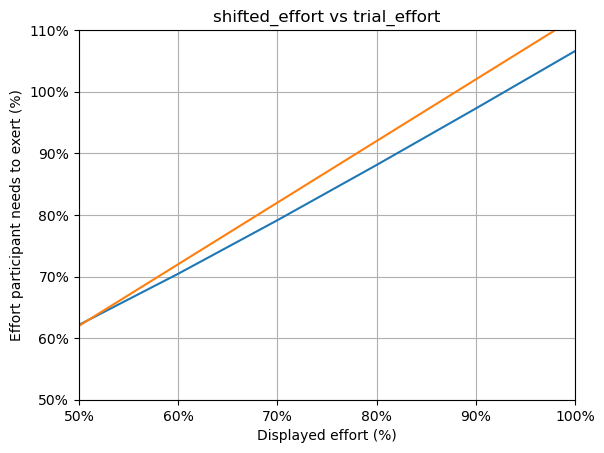

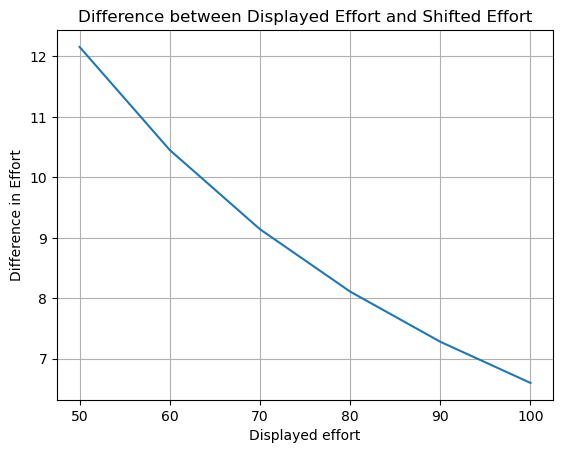

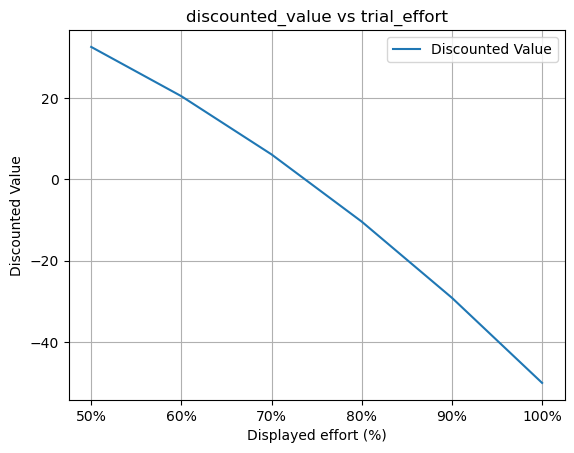

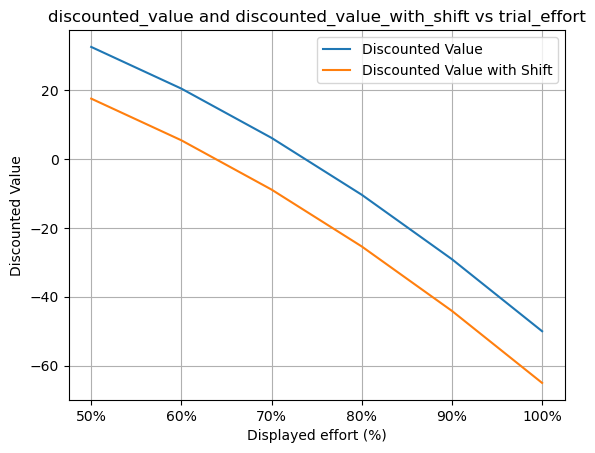

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Parameters
trial_effort = np.arange(50, 110, 10)
average_reward = 60
net_value_shift = 15
k = 1.1

# trial_effort = np.arange(0, 10.1, 0.01)
# average_reward = 60
# net_value_shift = 0.15
# k = 0.3

# Net value function
effort_level = trial_effort / 10
discounted_value = average_reward - k * effort_level**2

# Shifted effort  --> THIS IS WHAT I USE IN MY EXPERIMENT CODE
effort_level = trial_effort / 10
shifted_effort_level = np.sqrt((k * effort_level**2 + net_value_shift) / k)
shifted_effort = shifted_effort_level * 10

# Net value function with shifted effort
discounted_value_with_shift = average_reward - k * shifted_effort_level**2

# Plotting shifted_effort vs trial_effort (and a straight line for comparison to show that effort gets shifted less for higher effort levels)
plt.figure()
plt.plot(trial_effort, shifted_effort)
plt.plot(trial_effort, trial_effort+12)
plt.ylim(50, 110)
plt.xlim(50, 100)
plt.xlabel('Displayed effort (%)')
plt.ylabel('Effort participant needs to exert (%)')
plt.title('shifted_effort vs trial_effort')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}%'))
plt.show()

# Plotting the difference between trial_effort and shifted_effort vs trial_effort
plt.figure()
plt.plot(trial_effort, shifted_effort-trial_effort)
plt.xlabel('Displayed effort')
plt.ylabel('Difference in Effort')
plt.title('Difference between Displayed Effort and Shifted Effort')
plt.grid(True)
plt.show()


# Plotting discounted_value vs trial_effort
plt.figure()
plt.plot(trial_effort, discounted_value, label='Discounted Value')
plt.xlabel('Displayed effort (%)')
plt.ylabel('Discounted Value')
plt.title('discounted_value vs trial_effort')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.legend()
plt.show()

# Plotting discounted_value and discounted_value_with_shift vs trial_effort
plt.figure()
plt.plot(trial_effort, discounted_value, label='Discounted Value')
plt.plot(trial_effort, discounted_value_with_shift, label='Discounted Value with Shift')
plt.xlabel('Displayed effort (%)')
plt.ylabel('Discounted Value')
plt.title('discounted_value and discounted_value_with_shift vs trial_effort')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.legend()
plt.show()
